# 長程-平均價格_log-艙等分開

## 特徵重要性圖


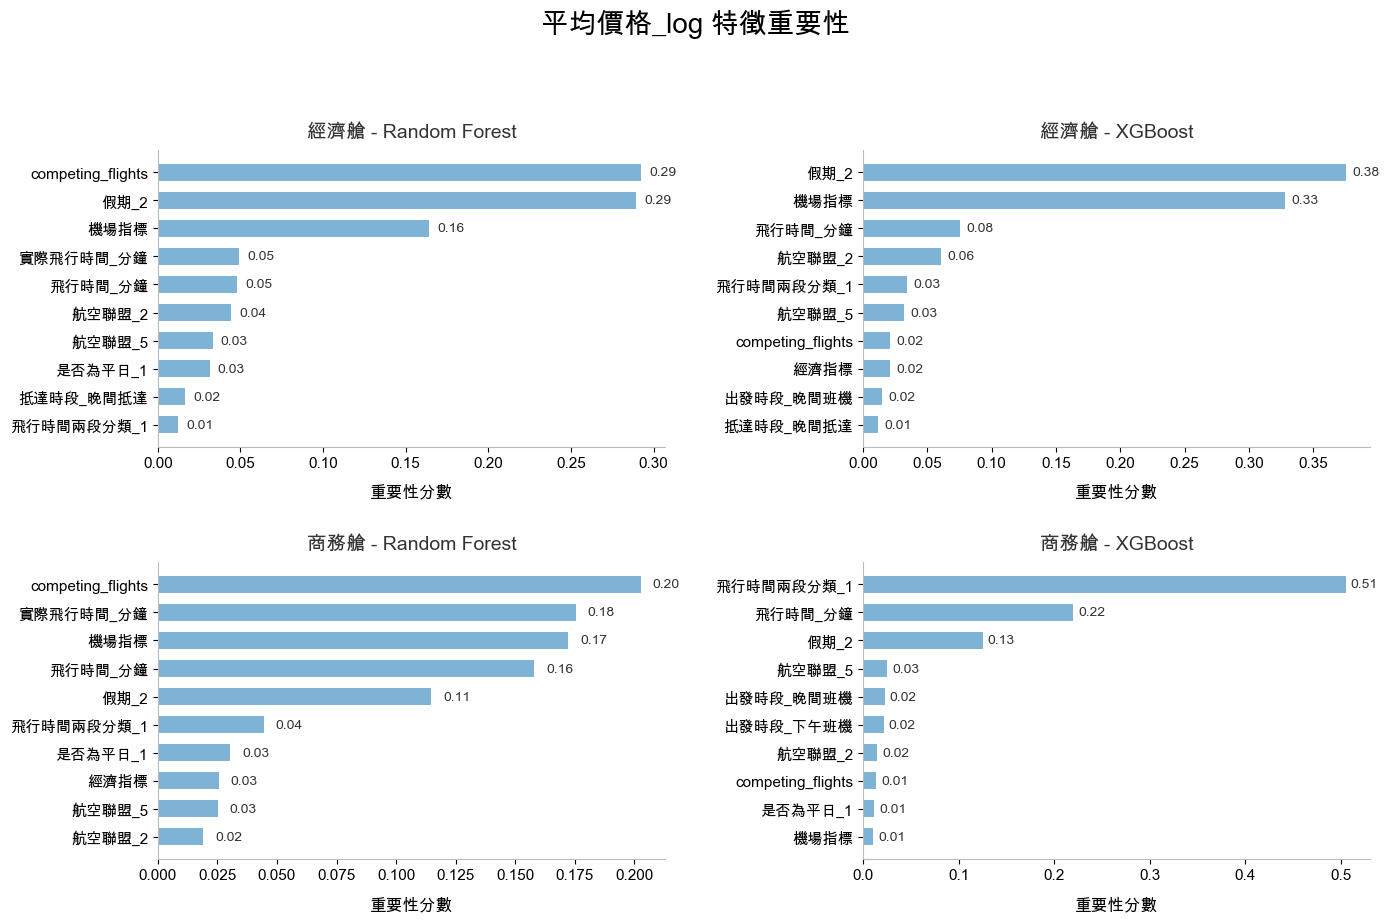

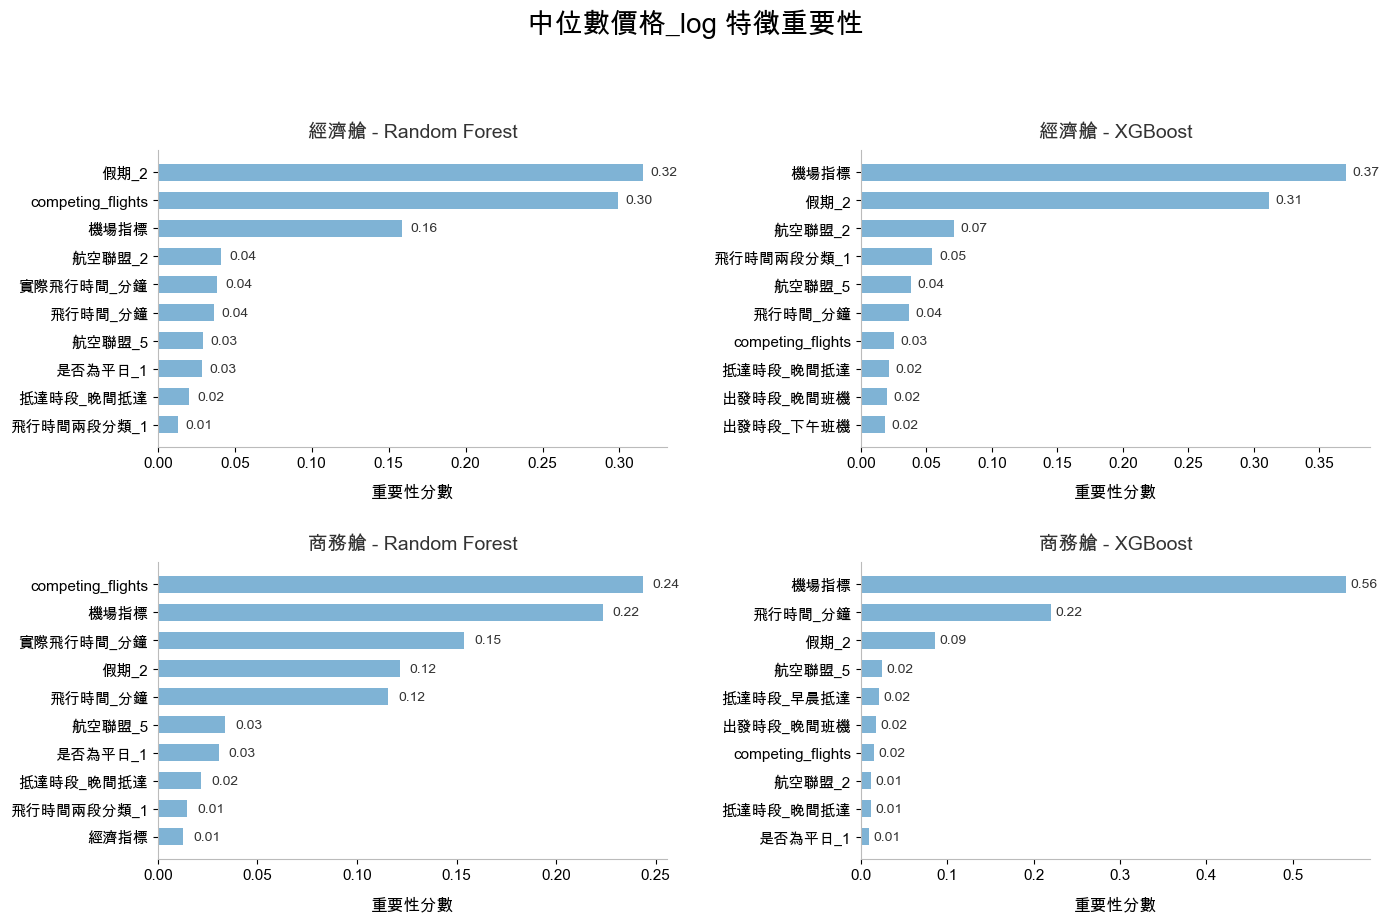

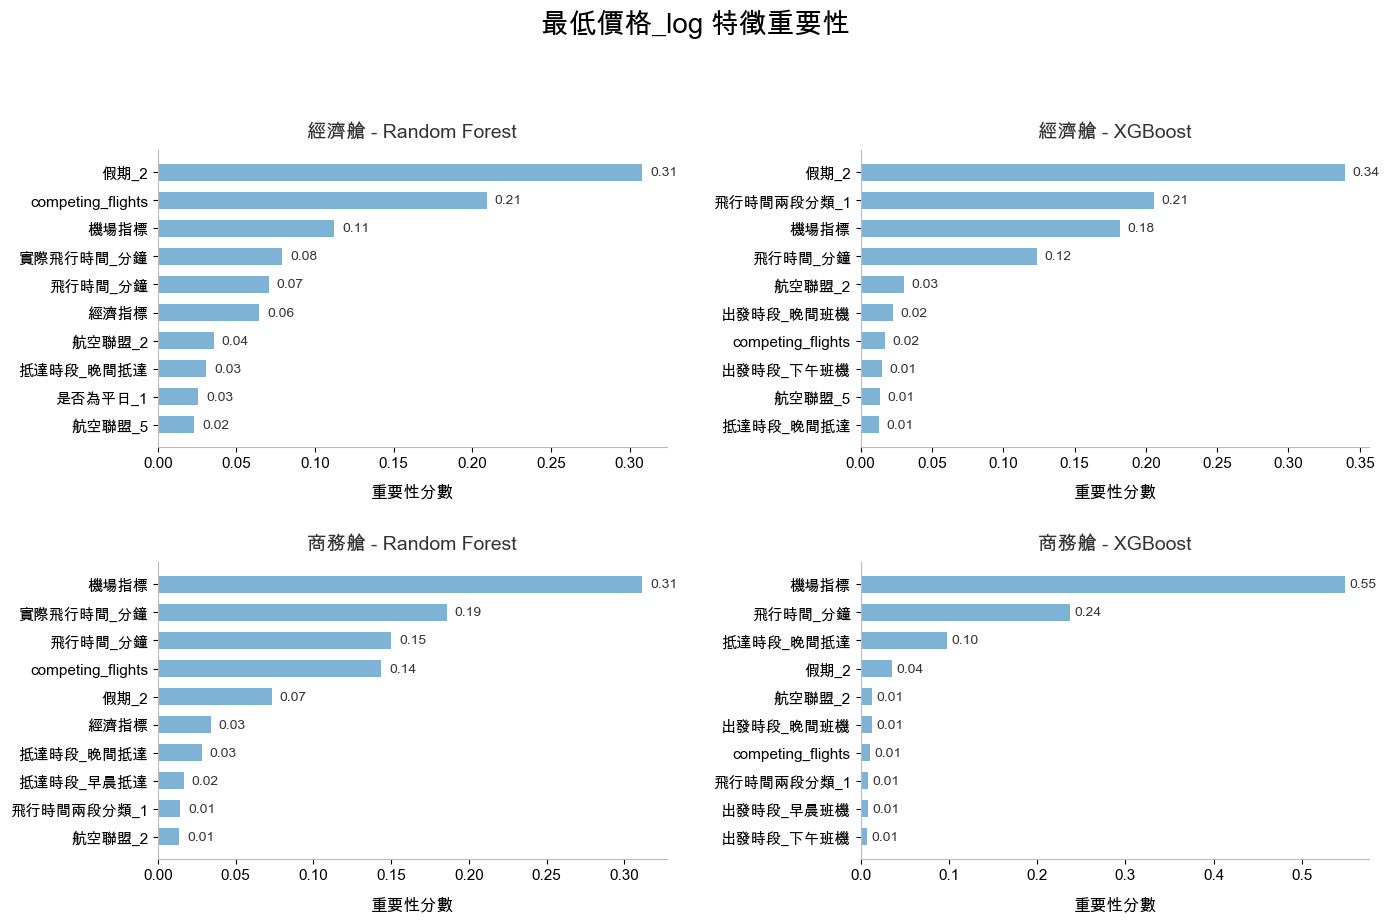

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter

# 中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 載入資料
file_path = '//Users/yuchingchen/Documents/專題/merge_and_cleaned/final_data/long_flight.csv'
data = pd.read_csv(file_path)

# 分離艙等
eco_data = data[data["艙等"] == "經濟艙"].copy()
biz_data = data[data["艙等"] == "商務艙"].copy()

# One-hot encoding
categorical_cols = ['出發時段', '出發機場代號', '抵達時段', '航空聯盟組合', '航空公司組合',
                   '航空聯盟', '停靠站數量', '機型分類', '假期', '飛行時間兩段分類', '是否為平日']
eco_data = pd.get_dummies(eco_data, columns=categorical_cols, drop_first=True)
biz_data = pd.get_dummies(biz_data, columns=categorical_cols, drop_first=True)

# 保留共同欄位
common_cols = list(set(eco_data.columns) & set(biz_data.columns))
eco_data = eco_data[common_cols]
biz_data = biz_data[common_cols]

# 標準化
num_cols = ['停留時間_分鐘', '飛行時間_分鐘', '實際飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
eco_data[num_cols] = scaler.fit_transform(eco_data[num_cols])
biz_data[num_cols] = scaler.transform(biz_data[num_cols])

# 特徵欄位
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空聯盟組合_', '航空公司組合_',
                   '航空聯盟_', '停靠站數量_', '機型分類_', '假期_', '飛行時間兩段分類_', '是否為平日_']
feature_cols = [col for col in eco_data.columns if any(k in col for k in target_keywords)] + num_cols
X_eco = eco_data[feature_cols]
X_biz = biz_data[feature_cols]

# 定義模型訓練 + 繪圖
def plot_importance(X, y_eco, y_biz, title):

    fig, axes = plt.subplots(2, 2, figsize=(14, 9))
    fig.suptitle(f"{title} 特徵重要性", fontsize=20, fontweight='bold', y=1.02)

    # 柔和藍色系
    bar_color = "#7FB3D5"
    text_color = "#333333"

    def draw_barh(ax, series, subtitle):
        top_features = series.sort_values(ascending=False).head(10)
        bars = ax.barh(top_features.index, top_features.values,
                       color=bar_color, edgecolor='none', height=0.6)
        ax.set_title(subtitle, fontsize=14, fontweight='semibold', color=text_color, pad=10)
        ax.set_xlabel("重要性分數", fontsize=12, labelpad=10)
        ax.tick_params(axis='both', labelsize=11)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#BBBBBB')
        ax.spines['bottom'].set_color('#BBBBBB')
        ax.invert_yaxis()

        # 加上數值標籤（靠右邊框對齊）
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                    f"{width:.2f}", va='center', fontsize=10, color=text_color)

    # 經濟艙
    rf = RandomForestRegressor(n_estimators=200, random_state=123, n_jobs=-1)
    rf.fit(X_eco, y_eco)
    rf_imp_eco = pd.Series(rf.feature_importances_, index=X_eco.columns)
    draw_barh(axes[0, 0], rf_imp_eco, "經濟艙 - Random Forest")

    xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6,
                       random_state=123, n_jobs=-1, verbosity=0)
    xgb.fit(X_eco, y_eco)
    xgb_imp_eco = pd.Series(xgb.feature_importances_, index=X_eco.columns)
    draw_barh(axes[0, 1], xgb_imp_eco, "經濟艙 - XGBoost")

    # 商務艙
    rf.fit(X_biz, y_biz)
    rf_imp_biz = pd.Series(rf.feature_importances_, index=X_biz.columns)
    draw_barh(axes[1, 0], rf_imp_biz, "商務艙 - Random Forest")

    xgb.fit(X_biz, y_biz)
    xgb_imp_biz = pd.Series(xgb.feature_importances_, index=X_biz.columns)
    draw_barh(axes[1, 1], xgb_imp_biz, "商務艙 - XGBoost")

    plt.tight_layout(h_pad=2.5, w_pad=2.5, rect=[0, 0, 1, 0.96])
    plt.show()

# 三種價格：平均、中位數、最低
plot_importance(X_eco, eco_data["平均價格_log"], biz_data["平均價格_log"], "平均價格_log")
plot_importance(X_eco, eco_data["中位數價格_log"], biz_data["中位數價格_log"], "中位數價格_log")
plot_importance(X_eco, eco_data["最低價格_log"], biz_data["最低價格_log"], "最低價格_log")

## 找最佳參數

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from scipy.stats import uniform, randint

# --------------------------
# 讀取與前處理資料
# --------------------------
file_path = '/Users/yuchingchen/Documents/專題/merge_and_cleaned/final_data/long_flight.csv'
data = pd.read_csv(file_path)

# 分艙等
economy_class_data = data[data["艙等（主航段）"] == "經濟艙"]
business_class_data = data[data["艙等（主航段）"] == "商務艙"]

# One-hot encoding
categorical_cols = ['出發時段', '出發機場代號', '抵達時段', '航空聯盟組合', '航空公司組合',
                   '航空聯盟', '停靠站數量', '機型分類', '假期', '飛行時間兩段分類', '是否為平日']
economy_class_data = pd.get_dummies(economy_class_data, columns=categorical_cols, drop_first=True)
business_class_data = pd.get_dummies(business_class_data, columns=categorical_cols, drop_first=True)

# 對齊欄位
common_cols = list(set(economy_class_data.columns) & set(business_class_data.columns))
economy_class_data = economy_class_data[common_cols]
business_class_data = business_class_data[common_cols]

# 標準化數值欄
num_cols = ['停留時間_分鐘', '實際飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
economy_class_data[num_cols] = scaler.fit_transform(economy_class_data[num_cols])
business_class_data[num_cols] = scaler.transform(business_class_data[num_cols])

# 特徵欄位
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空聯盟組合_', '航空公司組合_',
                   '航空聯盟_', '停靠站數量_', '機型分類_', '假期_', '飛行時間兩段分類_', '是否為平日_']
economy_class_data_dummy_cols = [col for col in economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
business_class_data_dummy_cols = [col for col in business_class_data.columns if any(keyword in col for keyword in target_keywords)]
economy_class_data_feature_cols = economy_class_data_dummy_cols + num_cols
business_class_data_feature_cols = business_class_data_dummy_cols + num_cols

# --------------------------
# 建模評估函式
# --------------------------
def run_model(seed, X, y, cabin_type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    result = {}

    # Random Forest
    rf_param_dist = {
        'n_estimators': randint(100, 300),
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5)
    }
    rf_model = RandomizedSearchCV(
        RandomForestRegressor(random_state=seed),
        rf_param_dist,
        n_iter=10, 
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=seed
    )
    rf_model.fit(X_train, y_train)
    print(f"[{cabin_type}] Best RF params (seed={seed}):", rf_model.best_params_) 
    y_pred_rf = rf_model.predict(X_test)
    result['RandomForest'] = get_metrics(y_test, y_pred_rf, n_test, p)

    # SVR（n_jobs=1，避免過多平行）
    svr_param_dist = {
        'C': uniform(0.1, 10),
        'epsilon': uniform(0.01, 1),
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf']
    }
    svr_model = RandomizedSearchCV(
        SVR(),
        svr_param_dist,
        n_iter=10,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=1, 
        random_state=seed
    )
    svr_model.fit(X_train, y_train)
    print(f"[{cabin_type}] Best SVR params (seed={seed}):", svr_model.best_params_) 
    y_pred_svr = svr_model.predict(X_test)
    result['SVR'] = get_metrics(y_test, y_pred_svr, n_test, p)

    # XGBoost（加入 tree_method）
    xgb_param_dist = {
        'n_estimators': randint(100, 300),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    }
    xgb_model = RandomizedSearchCV(
        XGBRegressor(random_state=seed, n_jobs=-1, verbosity=0, tree_method='hist'),
        xgb_param_dist,
        n_iter=10, 
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=seed
    )
    xgb_model.fit(X_train, y_train)
    print(f"[{cabin_type}] Best XGB params (seed={seed}):", xgb_model.best_params_)
    y_pred_xgb = xgb_model.predict(X_test)
    result['XGBoost'] = get_metrics(y_test, y_pred_xgb, n_test, p)

    return cabin_type, result

# 指標計算
def get_metrics(y_true, y_pred, n, p):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return {'MSE': mse, 'R2': r2, 'RMSE': rmse, 'Adjusted_R2': adj_r2}

# 結果統計
def process_results(all_results, cabin_type):
    results = {
        'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
    }

    for _, res in all_results:
        for model in results:
            for metric in results[model]:
                results[model][metric].append(res[model][metric])

    avg_results = {model: {metric: np.mean(values) for metric, values in metrics.items()} for model, metrics in results.items()}

    print(f"\n📊 {cabin_type} - Average Performance over {len(seeds)} runs:")
    for model, scores in avg_results.items():
        print(f"{model}:")
        for metric, value in scores.items():
            print(f"  {metric} = {value:.4f}")

# --------------------------
# 執行評估三個目標變數
# --------------------------
seeds = [123]

def evaluate_target_column(y_col):
    print(f"\n🎯 評估目標變數：{y_col}\n" + "-" * 50)
    # 經濟艙
    results_eco = Parallel(n_jobs=2)(delayed(run_model)(
        seed,
        economy_class_data[economy_class_data_feature_cols],
        economy_class_data[y_col],
        "經濟艙"
    ) for seed in seeds)

    # 商務艙
    results_biz = Parallel(n_jobs=2)(delayed(run_model)(
        seed,
        business_class_data[business_class_data_feature_cols],
        business_class_data[y_col],
        "商務艙"
    ) for seed in seeds)

    process_results(results_eco, "經濟艙")
    process_results(results_biz, "商務艙")

# 🎬 執行三個目標變數
for target in ['平均價格_log', '中位數價格_log', '最低價格_log']:
    evaluate_target_column(target)


🎯 評估目標變數：平均價格_log
--------------------------------------------------
[經濟艙] Best RF params (seed=123): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 253}
[經濟艙] Best SVR params (seed=123): {'C': 5.8969429702261005, 'epsilon': 0.14995076263038454, 'gamma': 'scale', 'kernel': 'rbf'}
[經濟艙] Best XGB params (seed=123): {'colsample_bytree': 0.8877875879142252, 'learning_rate': 0.1369319380373383, 'max_depth': 9, 'n_estimators': 196, 'subsample': 0.831877718809044}
[商務艙] Best RF params (seed=123): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 253}
[商務艙] Best SVR params (seed=123): {'C': 5.8969429702261005, 'epsilon': 0.14995076263038454, 'gamma': 'scale', 'kernel': 'rbf'}
[商務艙] Best XGB params (seed=123): {'colsample_bytree': 0.8877875879142252, 'learning_rate': 0.1369319380373383, 'max_depth': 9, 'n_estimators': 196, 'subsample': 0.831877718809044}

📊 經濟艙 - Average Performance over 1 runs:
RandomForest:
  MSE = 0.0290
  R2 

## 30次平均


==== 平均價格_log 平均表現 ====
經濟艙:
  RandomForest: MSE=0.0286, R2=0.9063
  SVR: MSE=0.0515, R2=0.8313
  XGBoost: MSE=0.0264, R2=0.9134
商務艙:
  RandomForest: MSE=0.0144, R2=0.8918
  SVR: MSE=0.0240, R2=0.8197
  XGBoost: MSE=0.0140, R2=0.8948


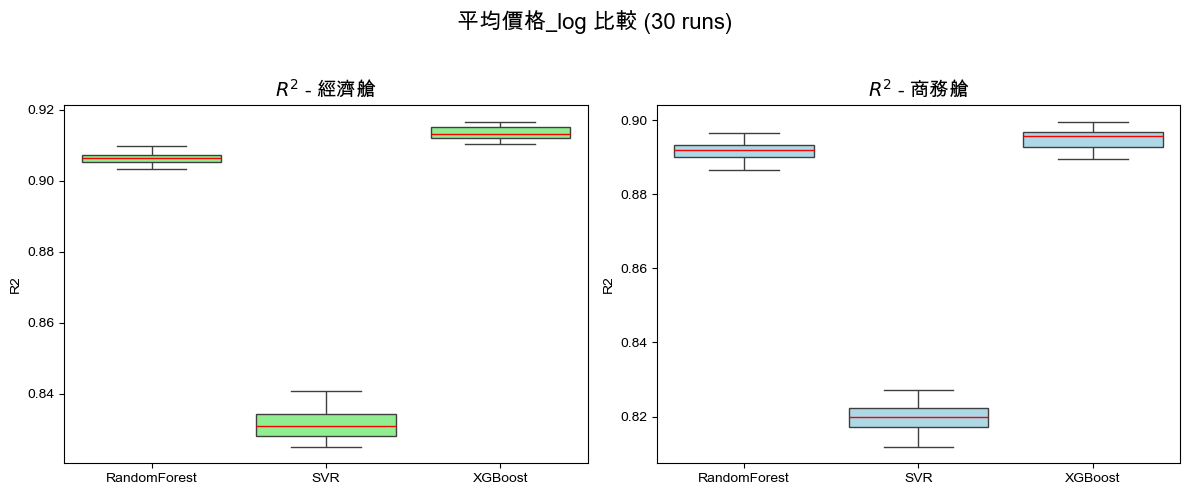


==== 中位數價格_log 平均表現 ====
經濟艙:
  RandomForest: MSE=0.0334, R2=0.8950
  SVR: MSE=0.0591, R2=0.8145
  XGBoost: MSE=0.0314, R2=0.9015
商務艙:
  RandomForest: MSE=0.0209, R2=0.8558
  SVR: MSE=0.0320, R2=0.7795
  XGBoost: MSE=0.0212, R2=0.8541


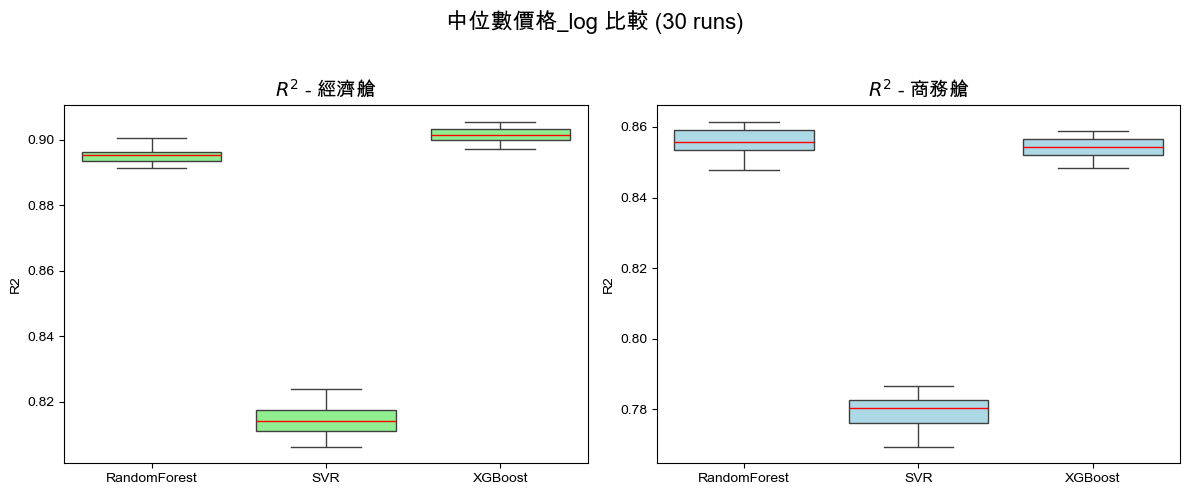


==== 最低價格_log 平均表現 ====
經濟艙:
  RandomForest: MSE=0.0237, R2=0.9229
  SVR: MSE=0.0442, R2=0.8563
  XGBoost: MSE=0.0227, R2=0.9263
商務艙:
  RandomForest: MSE=0.0111, R2=0.9160
  SVR: MSE=0.0237, R2=0.8203
  XGBoost: MSE=0.0116, R2=0.9123


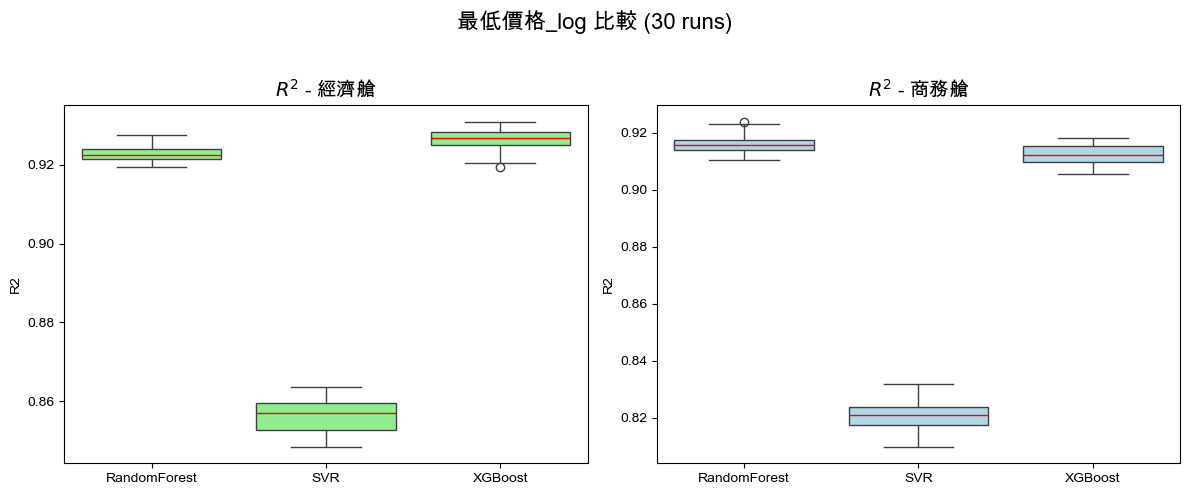

In [19]:
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed, parallel_backend
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# --------------------------
# 設定與前處理
# --------------------------
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

file_path = '/Users/yuchingchen/Documents/專題/merge_and_cleaned/final_data/long_flight.csv'
n_runs     = 30
seeds      = list(range(n_runs))

target_keywords = [
    '出發時段_', '出發機場代號_', '抵達時段_',
    '航空聯盟組合_', '航空公司組合_', '航空聯盟_',
    '停靠站數量_', '機型分類_', '假期_',
    '飛行時間兩段分類_', '是否為平日_'
]
num_cols = [
    '停留時間_分鐘', '實際飛行時間_分鐘',
    '經濟指標', '機場指標', 'competing_flights'
]
categorical_cols = [
    '出發時段', '出發機場代號', '抵達時段',
    '航空聯盟組合', '航空公司組合', '航空聯盟',
    '停靠站數量', '機型分類', '假期',
    '飛行時間兩段分類', '是否為平日'
]

data      = pd.read_csv(file_path)
econ_data = data[data["艙等（主航段）"]=="經濟艙"].copy()
biz_data  = data[data["艙等（主航段）"]=="商務艙"].copy()

econ_data = pd.get_dummies(econ_data, columns=categorical_cols, drop_first=True)
biz_data  = pd.get_dummies(biz_data,  columns=categorical_cols, drop_first=True)

common    = list(set(econ_data.columns)&set(biz_data.columns))
econ_data = econ_data[common]
biz_data  = biz_data[common]

scaler    = StandardScaler()
econ_data[num_cols] = scaler.fit_transform(econ_data[num_cols])
biz_data [num_cols] = scaler.transform(   biz_data [num_cols])

def get_features(df):
    dummies = [c for c in df.columns if any(k in c for k in target_keywords)]
    return dummies + num_cols

econ_feats = get_features(econ_data)
biz_feats  = get_features(biz_data)

# --------------------------
# 最佳參數字典
# --------------------------
best_params = {
    '平均價格_log': {
        '經濟艙': {
            'RandomForest': {'n_estimators':253,'max_depth':20,'min_samples_split':9,'min_samples_leaf':1},
            'SVR'         : {'C':5.8969,'epsilon':0.14995,'gamma':'scale'},
            'XGBoost'     : {'n_estimators':196,'learning_rate':0.136931938,'max_depth':9,'subsample':0.831877719,'colsample_bytree':0.887787588}
        },
        '商務艙': {
            'RandomForest': {'n_estimators':253,'max_depth':20,'min_samples_split':9,'min_samples_leaf':1},
            'SVR'         : {'C':5.8969,'epsilon':0.14995,'gamma':'scale'},
            'XGBoost'     : {'n_estimators':196,'learning_rate':0.136931938,'max_depth':9,'subsample':0.831877719,'colsample_bytree':0.887787588}
        }
    },
    '中位數價格_log': {
        '經濟艙': {
            'RandomForest': {'n_estimators':253,'max_depth':20,'min_samples_split':9,'min_samples_leaf':1},
            'SVR'         : {'C':5.8969,'epsilon':0.14995,'gamma':'scale'},
            'XGBoost'     : {'n_estimators':196,'learning_rate':0.136931938,'max_depth':9,'subsample':0.831877719,'colsample_bytree':0.887787588}
        },
        '商務艙': {
            'RandomForest': {'n_estimators':253,'max_depth':20,'min_samples_split':9,'min_samples_leaf':1},
            'SVR'         : {'C':5.8969,'epsilon':0.14995,'gamma':'scale'},
            'XGBoost'     : {'n_estimators':198,'learning_rate':0.095841800,'max_depth':7,'subsample':0.820525908,'colsample_bytree':0.878587674}
        }
    },
    '最低價格_log': {
        '經濟艙': {
            'RandomForest': {'n_estimators':253,'max_depth':20,'min_samples_split':9,'min_samples_leaf':1},
            'SVR'         : {'C':5.8969,'epsilon':0.14995,'gamma':'scale'},
            'XGBoost'     : {'n_estimators':196,'learning_rate':0.136931938,'max_depth':9,'subsample':0.831877719,'colsample_bytree':0.887787588}
        },
        '商務艙': {
            'RandomForest': {'n_estimators':253,'max_depth':20,'min_samples_split':9,'min_samples_leaf':1},
            'SVR'         : {'C':5.8969,'epsilon':0.14995,'gamma':'scale'},
            'XGBoost'     : {'n_estimators':198,'learning_rate':0.095841800,'max_depth':7,'subsample':0.820525908,'colsample_bytree':0.878587674}
        }
    }
}

# --------------------------
# run_model
# --------------------------
def run_model(seed, X, y, params):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test, p = len(yte), X.shape[1]
    out = {}
    models = {
        'RandomForest': RandomForestRegressor(random_state=seed, n_jobs=1, **params['RandomForest']),
        'SVR'         : SVR(**params['SVR']),
        'XGBoost'     : XGBRegressor(random_state=seed, n_jobs=1, tree_method='hist', **params['XGBoost'])
    }
    for name, mdl in models.items():
        mdl.fit(Xtr, ytr)
        pred = mdl.predict(Xte)
        mse  = mean_squared_error(yte, pred)
        r2   = r2_score(yte, pred)
        adj  = 1 - (1-r2)*(n_test-1)/(n_test-p-1)
        out[name] = {'MSE': mse, 'R2': r2, 'Adjusted_R2': adj}
    return out

# --------------------------
# process_results & plot
# --------------------------
def process_results(results_list):
    agg = {m:{'MSE':[], 'R2':[]} for m in results_list[0].keys()}
    for res in results_list:
        for m in agg:
            agg[m]['MSE'].append(res[m]['MSE'])
            agg[m]['R2'].append(res[m]['R2'])
    summary = {m:{'Average MSE':np.mean(v['MSE']), 'Average R2':np.mean(v['R2'])}
               for m,v in agg.items()}
    return summary, agg

def plot_r2_boxplots(econ_r2, biz_r2, title):
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    def single_box(ax, r2_dict, cabin, color):
        df = pd.DataFrame(r2_dict).melt(var_name='Model', value_name='R2')
        sns.boxplot(x='Model', y='R2', data=df, ax=ax,
                    boxprops={'facecolor':color}, medianprops={'color':'red'})
        ax.set_title(f"$R^2$ - {cabin}", fontsize=14)
        ax.set_xlabel('')
    single_box(axes[0], econ_r2, '經濟艙', 'lightgreen')
    single_box(axes[1], biz_r2,  '商務艙', 'lightblue')
    fig.suptitle(f"{title} 比較 ({n_runs} runs)", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# --------------------------
# 執行主程式
# --------------------------
for target in ['平均價格_log','中位數價格_log','最低價格_log']:
    econ_p = best_params[target]['經濟艙']
    biz_p  = best_params[target]['商務艙']

    with parallel_backend('threading'):
        econ_out = Parallel(n_jobs=-1)(
            delayed(run_model)(s, econ_data[econ_feats], econ_data[target], econ_p)
            for s in seeds
        )
        biz_out  = Parallel(n_jobs=-1)(
            delayed(run_model)(s, biz_data[biz_feats],  biz_data[target],  biz_p)
            for s in seeds
        )

    econ_summary, econ_agg = process_results(econ_out)
    biz_summary,  biz_agg  = process_results(biz_out)

    print(f"\n==== {target} 平均表現 ====")
    for cabin, summ in [('經濟艙', econ_summary), ('商務艙', biz_summary)]:
        print(f"{cabin}:")
        for model, scores in summ.items():
            print(f"  {model}: MSE={scores['Average MSE']:.4f}, R2={scores['Average R2']:.4f}")

    econ_r2 = {m:v['R2'] for m,v in econ_agg.items()}
    biz_r2  = {m:v['R2'] for m,v in biz_agg.items()}
    plot_r2_boxplots(econ_r2, biz_r2, target)